In [1]:
import pandas as pd
from glob import glob
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from Bio import SeqIO
import os
import gzip
import json
import numpy as np

data = "1500"
max_assembly = 500
min_samples = 3

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["figure.figsize"] = (5, 3)

/tmp/ipykernel_30416/628076980.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
ip_names = pd.read_csv("https://ftp.ebi.ac.uk/pub/databases/interpro/current_release/entry.list",sep="\t",header=0)
ip_names.set_index("ENTRY_AC",inplace=True)

ip_names["ENTRY_NAME"] = ip_names["ENTRY_NAME"].str.replace("[","_").str.replace("]","_").str.replace("<","_")

rels =	[i.split("/")[-1].split(".")[0] for i in glob(f"/home/gomez/gomez/xgboost/annotations{data}_{max_assembly}/*.pkl")]

### Read in the data

In [3]:
with open(f'/home/gomez/gomez/xgboost/annotations{data}_{max_assembly}/binary/binary_{min_samples}.pkl', 'rb') as f:
	d = pickle.load(f)

/home/gomez/miniconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:36:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1712072663242/work/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [4]:
l = []
for rel in tqdm(rels):
	for i in range(len(d[rel])):
		s = pd.Series(d[rel][i][2].get_score(importance_type="gain"))
		if len(s) > 0:
			first_gene = s.sort_values(ascending=False).index[0]
			first_value = s.sort_values(ascending=False)[0]
			ner = d[rel][i][0][0]
			if len(s) >= 2:
				second_value = s.sort_values(ascending=False)[1]
				second_gene = s.sort_values(ascending=False).index[1]
			else:
				second_value = 0
				second_gene = ""
			if len(s) >= 3:
				third_value = s.sort_values(ascending=False)[2]
				third_gene = s.sort_values(ascending=False).index[2]
			else:
				third_value = 0
				third_gene = ""
			if len(s) >= 4:
				last_value = s.sort_values(ascending=False)[-1]
				last_gene = s.sort_values(ascending=False).index[-1]
			else:
				last_value = 0
				last_gene = ""
			l.append([rel, ner, first_value, first_gene, second_value, second_gene, third_value, third_gene, last_value, last_gene])


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_30416/2750966354.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_value = s.sort_values(ascending=False)[0]
/tmp/ipykernel_30416/2750966354.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  second_value = s.sort_values(ascending=False)[1]
/tmp/ipykernel_30416/2750966354.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  third_value = s.sort_values(ascending=False)[2]
/tmp/ipykernel_30416/2750966354.py:22

In [5]:
df = pd.DataFrame(l,columns=["rel","ner","first_value","first_gene","second_value","second_gene","third_value","third_gene","last_value","last_gene"])

In [6]:
df

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene
0,STRAIN-ORGANISM:SYMBIONT_OF,soybean,7.194476,Ribosomal RNA adenine methyltransferase KsgA/Erm,5.896133,OST-HTH/LOTUS domain,4.183388,GroES chaperonin family,1.408641,Flavodoxin-like fold
1,STRAIN-ORGANISM:SYMBIONT_OF,legume,4.678845,"Transposase InsH, N-terminal",4.505929,Ureidoglycolate lyase,4.383556,"DNA ligase D, polymerase domain",2.504514,Protein of unknown function DUF1427
2,STRAIN-ORGANISM:SYMBIONT_OF,heterorhabditis nematodes,2.286017,Cation efflux protein,2.258519,Uncharacterised protein family UPF0270,2.256283,Beta-lactamase-related,0.721357,"PurM-like, C-terminal domain"
3,STRAIN-ORGANISM:SYMBIONT_OF,phaseolus,2.261282,"Zinc finger, UBP-type",2.252906,Protein of unknown function DUF2442,2.251882,"Mycobacterial 4 TMS phage holin, superfamily IV",1.006524,"Molybdopterin dehydrogenase, FAD-binding"
4,STRAIN-ORGANISM:SYMBIONT_OF,peanut,2.269805,Methyltransferase domain 25,2.258519,"Membrane bound O-acyl transferase, MBOAT",2.257047,Cytochrome c oxidase subunit II-like C-terminal,0.725012,Acetoacetate decarboxylase
...,...,...,...,...,...,...,...,...,...,...
11158,STRAIN-MEDIUM:GROWS_ON,glycerol stocks,1.899701,"Transcription termination factor, mitochondria...",1.303782,"Cpl-7 lysozyme, C-terminal",1.187278,Protein of unknown function DUF1642,0.523319,"Replication initiator A, N-terminal"
11159,STRAIN-MEDIUM:GROWS_ON,harvs,2.910431,Beta-lactamase-inhibitor protein BLIP,2.619363,SMODS and SLOG-associating 2TM effector domain 1,2.602852,A-factor biosynthesis hotdog domain,0.595113,Carbonic anhydrase
11160,STRAIN-MEDIUM:GROWS_ON,glycerol-,0.866605,"Ribbon-helix-helix protein, CopG",0.799189,Acyl transferase,0.740322,Mycobacterial pentapeptide repeat,0.000251,"Integrase, catalytic core"
11161,STRAIN-MEDIUM:GROWS_ON,hayflick broth supplemented,2.621537,Adhesin lipoprotein,1.432926,LMP repeat,1.425790,Lipoprotein-associated domain,0.000000,


In [7]:
cutoff = df[df["first_value"] > 0.15].sort_values("first_value")

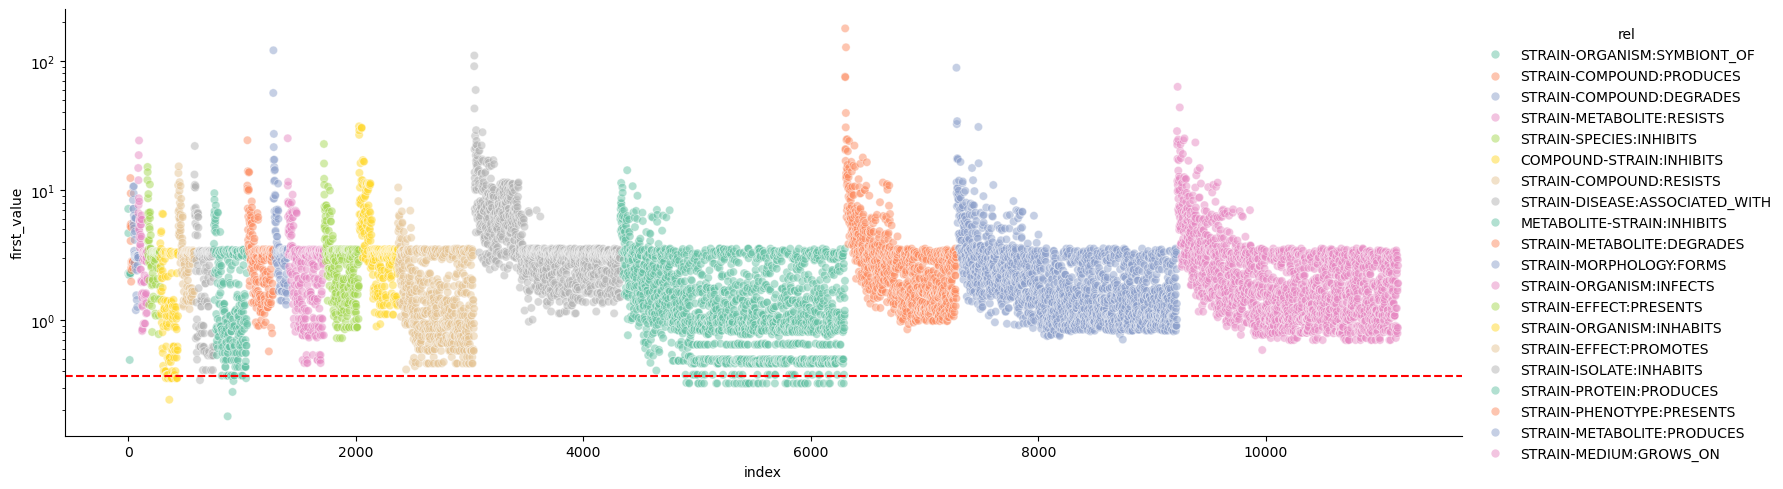

In [8]:
sns.relplot(y="first_value", x="index", hue="rel", data=df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')
plt.yscale("log")

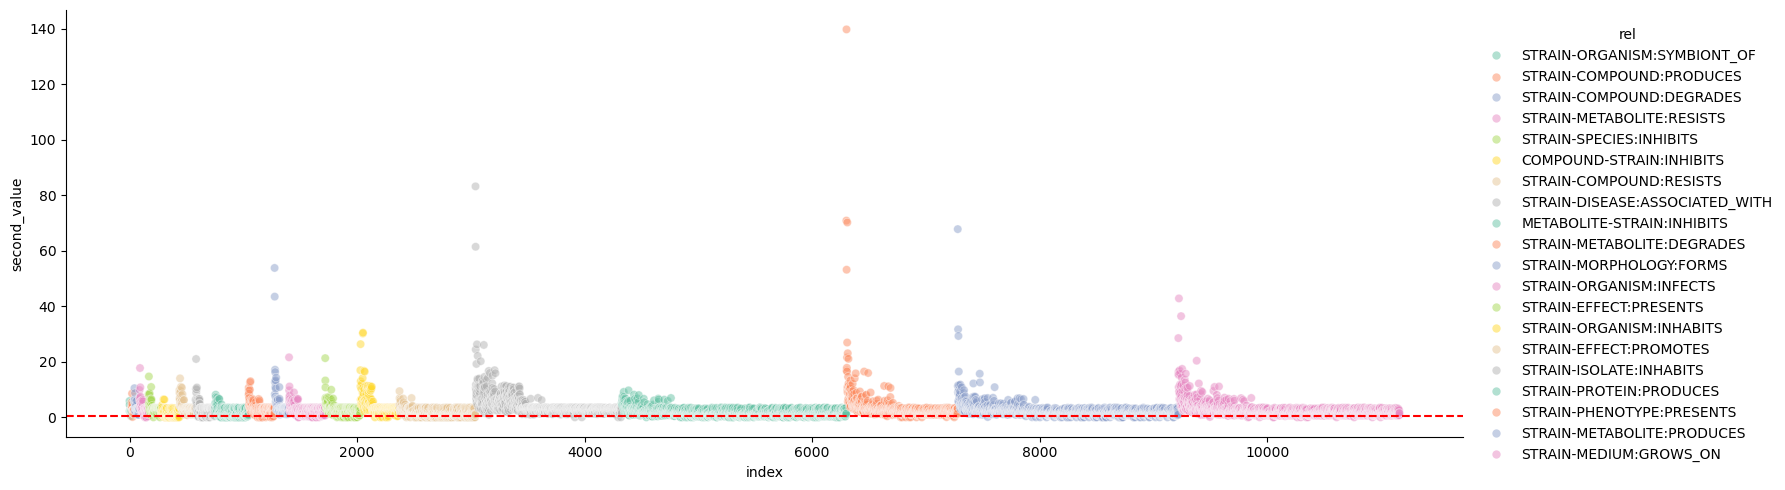

In [9]:
sns.relplot(y="second_value", x="index", hue="rel", data=df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

add value counts and check whether these play a role in the value significance. if it does, we could consider normalizing by this value

<Axes: ylabel='Frequency'>

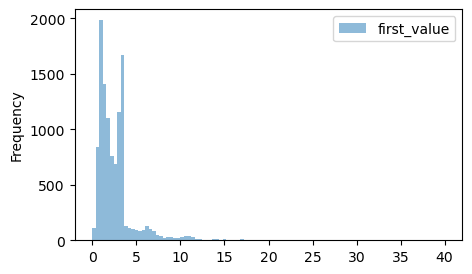

In [10]:
df.plot(kind='hist',y="first_value",bins=100,range=(0,40),alpha=0.5)

#### Group by function

In [11]:
df

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene
0,STRAIN-ORGANISM:SYMBIONT_OF,soybean,7.194476,Ribosomal RNA adenine methyltransferase KsgA/Erm,5.896133,OST-HTH/LOTUS domain,4.183388,GroES chaperonin family,1.408641,Flavodoxin-like fold
1,STRAIN-ORGANISM:SYMBIONT_OF,legume,4.678845,"Transposase InsH, N-terminal",4.505929,Ureidoglycolate lyase,4.383556,"DNA ligase D, polymerase domain",2.504514,Protein of unknown function DUF1427
2,STRAIN-ORGANISM:SYMBIONT_OF,heterorhabditis nematodes,2.286017,Cation efflux protein,2.258519,Uncharacterised protein family UPF0270,2.256283,Beta-lactamase-related,0.721357,"PurM-like, C-terminal domain"
3,STRAIN-ORGANISM:SYMBIONT_OF,phaseolus,2.261282,"Zinc finger, UBP-type",2.252906,Protein of unknown function DUF2442,2.251882,"Mycobacterial 4 TMS phage holin, superfamily IV",1.006524,"Molybdopterin dehydrogenase, FAD-binding"
4,STRAIN-ORGANISM:SYMBIONT_OF,peanut,2.269805,Methyltransferase domain 25,2.258519,"Membrane bound O-acyl transferase, MBOAT",2.257047,Cytochrome c oxidase subunit II-like C-terminal,0.725012,Acetoacetate decarboxylase
...,...,...,...,...,...,...,...,...,...,...
11158,STRAIN-MEDIUM:GROWS_ON,glycerol stocks,1.899701,"Transcription termination factor, mitochondria...",1.303782,"Cpl-7 lysozyme, C-terminal",1.187278,Protein of unknown function DUF1642,0.523319,"Replication initiator A, N-terminal"
11159,STRAIN-MEDIUM:GROWS_ON,harvs,2.910431,Beta-lactamase-inhibitor protein BLIP,2.619363,SMODS and SLOG-associating 2TM effector domain 1,2.602852,A-factor biosynthesis hotdog domain,0.595113,Carbonic anhydrase
11160,STRAIN-MEDIUM:GROWS_ON,glycerol-,0.866605,"Ribbon-helix-helix protein, CopG",0.799189,Acyl transferase,0.740322,Mycobacterial pentapeptide repeat,0.000251,"Integrase, catalytic core"
11161,STRAIN-MEDIUM:GROWS_ON,hayflick broth supplemented,2.621537,Adhesin lipoprotein,1.432926,LMP repeat,1.425790,Lipoprotein-associated domain,0.000000,


In [12]:
df.value_counts("first_gene")

first_gene
Bacteriophage lambda, Tail fiber protein, repeat-2            148
Mycobacterial pentapeptide repeat                              92
Exostosin, GT47 domain                                         89
DNA-directed RNA polymerase, C-terminal domain, phage-type     89
Glycosyl hydrolases family 2, sugar binding domain             87
                                                             ... 
Protein of unknown function DUF1391                             1
Domain of unknown function DUF4401                              1
Domain of unknown function DUF4369                              1
Domain of unknown function DUF4367                              1
vWA-MoxR associated protein middle region 1                     1
Name: count, Length: 4365, dtype: int64

In [13]:
df[df["first_gene"]=="Bacteriophage lambda, Tail fiber protein, repeat-2"].sort_values("first_value")

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene
5574,STRAIN-PROTEIN:PRODUCES,rbet v 1,0.482991,"Bacteriophage lambda, Tail fiber protein, repe...",0.470827,"ShET2 enterotoxin, N-terminal",0.423006,"DNA-directed RNA polymerase, C-terminal domain...",0.000808,AAA domain
5653,STRAIN-PROTEIN:PRODUCES,ctr,0.482991,"Bacteriophage lambda, Tail fiber protein, repe...",0.470827,"ShET2 enterotoxin, N-terminal",0.423006,"DNA-directed RNA polymerase, C-terminal domain...",0.000808,AAA domain
5640,STRAIN-PROTEIN:PRODUCES,crc,0.482991,"Bacteriophage lambda, Tail fiber protein, repe...",0.470827,"ShET2 enterotoxin, N-terminal",0.423006,"DNA-directed RNA polymerase, C-terminal domain...",0.000808,AAA domain
5638,STRAIN-PROTEIN:PRODUCES,cre,0.482991,"Bacteriophage lambda, Tail fiber protein, repe...",0.470827,"ShET2 enterotoxin, N-terminal",0.423006,"DNA-directed RNA polymerase, C-terminal domain...",0.000808,AAA domain
5622,STRAIN-PROTEIN:PRODUCES,rel,0.482991,"Bacteriophage lambda, Tail fiber protein, repe...",0.470827,"ShET2 enterotoxin, N-terminal",0.423006,"DNA-directed RNA polymerase, C-terminal domain...",0.000808,AAA domain
...,...,...,...,...,...,...,...,...,...,...
7894,STRAIN-METABOLITE:PRODUCES,emulsan,1.467563,"Bacteriophage lambda, Tail fiber protein, repe...",1.377979,Protein of unknown function DUF6216,1.377889,Domain of unknown function DUF3672,0.003687,"ShET2 enterotoxin, N-terminal"
7843,STRAIN-METABOLITE:PRODUCES,α-carotene,1.547760,"Bacteriophage lambda, Tail fiber protein, repe...",1.389454,Cytochrome c-like domain,1.206110,Domain of unknown function DUF3672,0.007469,HTH-like domain
7374,STRAIN-METABOLITE:PRODUCES,butanediol,1.878533,"Bacteriophage lambda, Tail fiber protein, repe...",1.776482,Protein of unknown function DUF2732,1.726051,Phage spike trimer,0.000188,"Translation elongation factor EFTu-like, domain 2"
5276,STRAIN-PROTEIN:PRODUCES,stx,3.242305,"Bacteriophage lambda, Tail fiber protein, repe...",3.065272,Domain of unknown function DUF1737,3.002667,"Haemolysin expression modulating, HHA",0.366692,TRAP C4-dicarboxylate transport system permeas...


#### Calculate number of assemblies per NER

TODO: Calculate also species per NER?

In [14]:
assemblies_perner = []
for rel in tqdm(rels):
	d[rel]= []
	filepath = f"/home/gomez/gomez/xgboost/annotations{data}_{max_assembly}/{rel}.pkl"
	# Read the pickle file
	with open(filepath, "rb") as f:
		dat = pickle.load(f)
	vc = pd.DataFrame(pd.DataFrame(dat[1]).value_counts())
	vc["rel"] = rel
	assemblies_perner.append(vc)
	

  0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
assemblies = pd.concat(assemblies_perner)

In [16]:
merged_df = df.merge(assemblies,left_on=["rel","ner"],right_on=["rel",0])

In [17]:
merged_df.sort_values("count")

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count
5581,STRAIN-PROTEIN:PRODUCES,rag1,0.482991,"Bacteriophage lambda, Tail fiber protein, repe...",0.470827,"ShET2 enterotoxin, N-terminal",0.423006,"DNA-directed RNA polymerase, C-terminal domain...",0.000808,AAA domain,3
6111,STRAIN-PROTEIN:PRODUCES,glf,0.864563,"Exostosin, GT47 domain",0.752824,Protein HHL1-like,0.747305,Acireductone dioxygenase ARD family,0.000166,"DNA primase/polymerase, bifunctional, N-terminal",3
6110,STRAIN-PROTEIN:PRODUCES,glgp,0.864563,"Exostosin, GT47 domain",0.752824,Protein HHL1-like,0.747305,Acireductone dioxygenase ARD family,0.000166,"DNA primase/polymerase, bifunctional, N-terminal",3
6109,STRAIN-PROTEIN:PRODUCES,glp-1,3.379883,Mucin binding domain,1.631364,Mub B2-like domain,0.429523,NAD-dependent epimerase/dehydratase,0.000000,,3
6108,STRAIN-PROTEIN:PRODUCES,glpr,0.937645,"Type I toxin-antitoxin system, toxin Ldr",0.816314,Protein of unknown function DUF5431,0.802677,"Bacteriophage Sf6, terminase small subunit-like",0.000027,Protein kinase domain,3
...,...,...,...,...,...,...,...,...,...,...,...
3041,STRAIN-ISOLATE:INHABITS,soil,90.904259,Phosphotriesterase,83.257385,"Penicillin-binding protein, transpeptidase",72.634460,Catalase immune-responsive domain,0.029880,"Prepilin type IV endopeptidase, peptidase domain",488
9219,STRAIN-MEDIUM:GROWS_ON,lb,28.670624,"Mechanosensitive ion channel, conserved TM helix",28.564880,Sodium:dicarboxylate symporter,24.760025,"CTP synthase, N-terminal",0.000279,"Terminase large subunit GpA, endonuclease domain",534
6302,STRAIN-PHENOTYPE:PRESENTS,gram - positive,178.178009,"Sporulation transcription regulator WhiA, N-te...",139.847794,Bacterial surface antigen (D15),64.635696,Permease LptG/LptF-related,0.000635,Toxin HigB-like,706
6301,STRAIN-PHENOTYPE:PRESENTS,gram - negative,75.537033,"Proteinase inhibitor I11, ecotin",70.920799,Outer membrane lipoprotein LolB,58.592335,"Uncharacterised protein family UPF0250, YbeD-like",0.000244,Adenylyl cyclase class-3/4/guanylyl cyclase,770


/tmp/ipykernel_30416/1829732332.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(y="first_value", x="count", col="rel", data=merged_df,aspect=2, height=2, palette="Set2",col_wrap=5, alpha=.5)


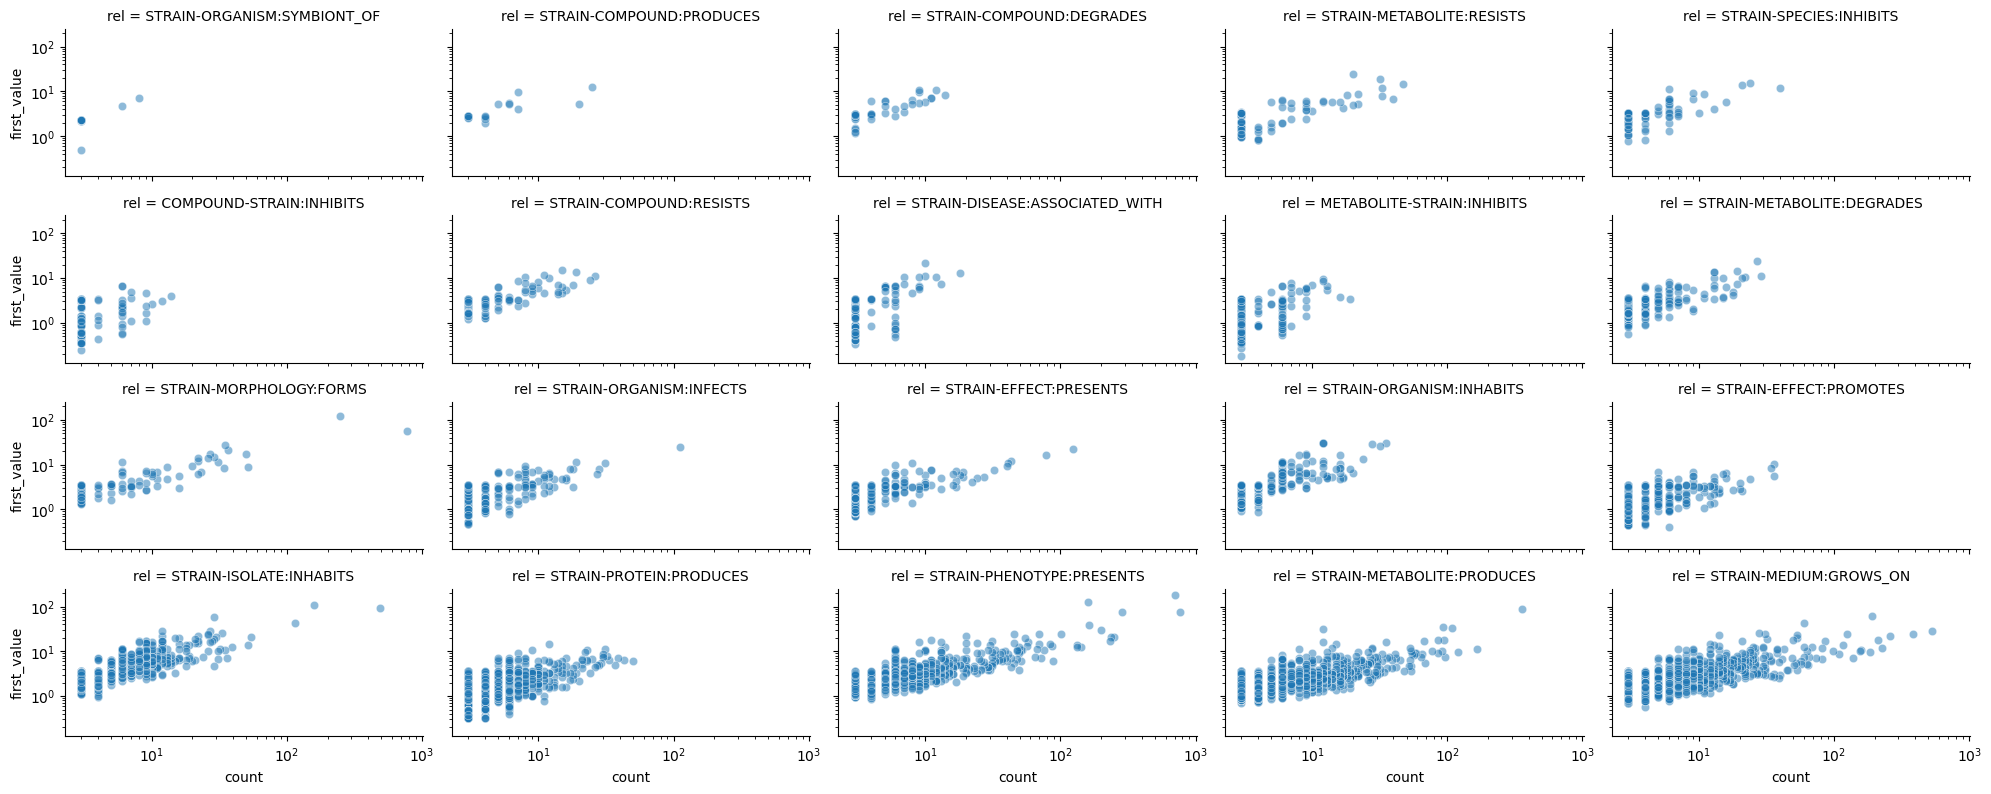

In [18]:
sns.relplot(y="first_value", x="count", col="rel", data=merged_df,aspect=2, height=2, palette="Set2",col_wrap=5, alpha=.5)
plt.xscale("log")
plt.yscale("log")

#### Try to normalize by the number of assemblies per NER

In [19]:
merged_df['normalized_value'] = merged_df['first_value'] / merged_df['count']


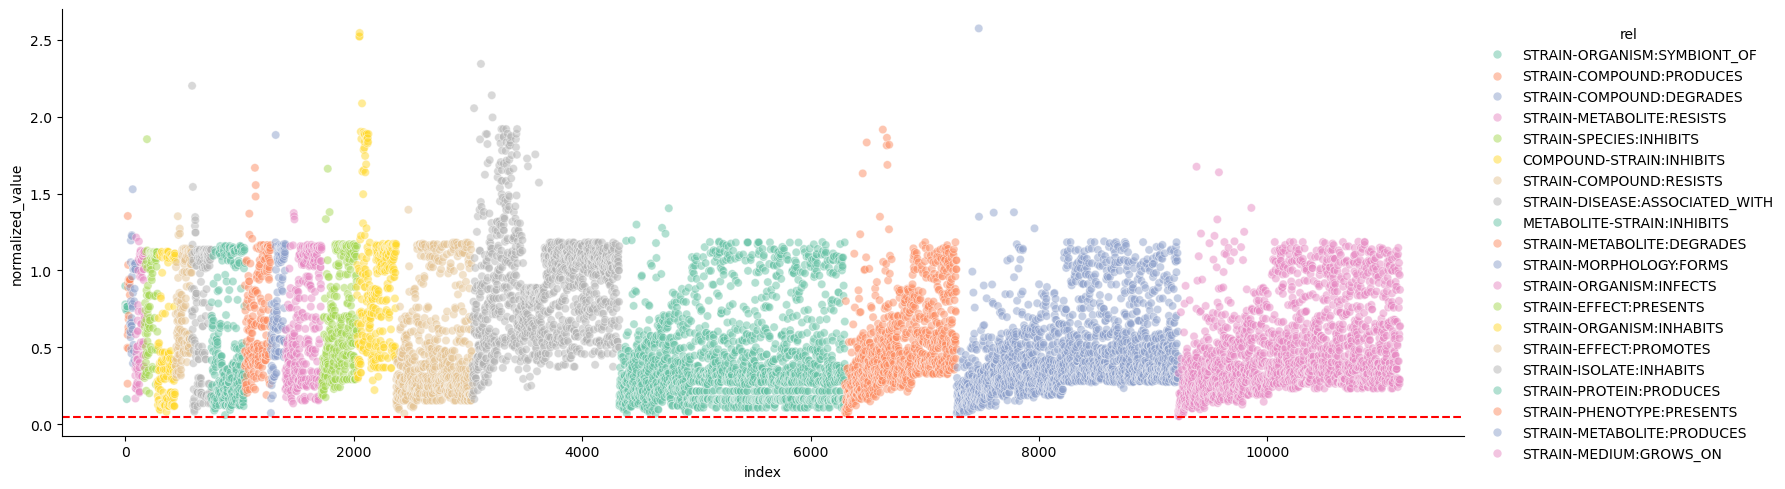

In [20]:
sns.relplot(y="normalized_value", x="index", hue="rel", data=merged_df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.05, color='r', linestyle='--')

In [21]:
merged_df.sort_values("normalized_value")

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count,normalized_value
9228,STRAIN-MEDIUM:GROWS_ON,pbs,7.095319,tRNA-binding domain,6.593839,PBP domain,6.301677,Ribonucleotide reductase N-terminal,0.003361,"UvrB, interaction domain",138,0.051415
9222,STRAIN-MEDIUM:GROWS_ON,luria-bertani,11.800794,"Branched-chain amino acid transport, permease",10.873153,AraC-type arabinose-binding/dimerisation domain,9.914643,F plasmid transfer operon protein,0.001017,Glycosyl transferase WecG/TagA/CpsF,226,0.052216
9225,STRAIN-MEDIUM:GROWS_ON,nb,9.750107,Putative mucin/carbohydrate-binding domain,9.329365,Catalase immune-responsive domain,9.017354,"4Fe-4S ferredoxin-type, iron-sulphur binding d...",0.001883,"Phage terminase large subunit GpA, ATPase domain",185,0.052703
9219,STRAIN-MEDIUM:GROWS_ON,lb,28.670624,"Mechanosensitive ion channel, conserved TM helix",28.564880,Sodium:dicarboxylate symporter,24.760025,"CTP synthase, N-terminal",0.000279,"Terminase large subunit GpA, endonuclease domain",534,0.053690
874,METABOLITE-STRAIN:INHIBITS,thiophosphates,0.179843,"PE-PGRS family, N-terminal",0.169731,Adenylyl cyclase class-3/4/guanylyl cyclase,0.156257,Phosphoesterase,0.131961,PGRS repeats,3,0.059948
...,...,...,...,...,...,...,...,...,...,...,...,...
3114,STRAIN-ISOLATE:INHABITS,sediments of an active hydrothermal vent,28.114807,Protein of unknown function DUF4894,26.090393,"Proteinase inhibitor I42, chagasin",17.284296,Domain of unknown function DUF4896,0.229835,Cytochrome c oxidase subunit III-like,12,2.342901
2051,STRAIN-ORGANISM:INHABITS,casuarina,30.249023,Pterin 4 alpha carbinolamine dehydratase,30.239853,Cobalamin (vitamin B12)-binding domain,7.700626,Protein of unknown function DUF6027,3.138637,Protein of unknown function DUF5825,12,2.520752
2049,STRAIN-ORGANISM:INHABITS,soybean plant,30.249023,"Transposase TnpC, homeodomain",14.119650,"Transposase IS116/IS110/IS902, C-terminal",13.233068,"Transposase IS66, central domain",0.307140,O-methyltransferase domain,12,2.520752
2052,STRAIN-ORGANISM:INHABITS,p. larvae,30.530426,"L-tyrosine decarboxylase, C-terminal",30.517075,ADP ribosyltransferase,30.239853,"Oligopeptide transporter, OPT superfamily",0.288379,DMSO/Nitrate reductase chaperone,12,2.544202


#### Find features where top three are very close

In [22]:
merged_df["first_second_difference"] = merged_df.first_value - merged_df.second_value
merged_df["first_third_difference"] = merged_df.first_value - merged_df.third_value

In [23]:
merged_df[merged_df["first_second_difference"] <0.01]

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count,normalized_value,first_second_difference,first_third_difference
3,STRAIN-ORGANISM:SYMBIONT_OF,phaseolus,2.261282,"Zinc finger, UBP-type",2.252906,Protein of unknown function DUF2442,2.251882,"Mycobacterial 4 TMS phage holin, superfamily IV",1.006524,"Molybdopterin dehydrogenase, FAD-binding",3,0.753761,0.008376,0.009400
5,STRAIN-ORGANISM:SYMBIONT_OF,mosquito,2.261282,"UDP-glucose/GDP-mannose dehydrogenase, dimeris...",2.252906,Pyrrolo-quinoline quinone repeat,2.251718,Tail tube protein,0.703421,"Membrane lipoprotein, lipid attachment site",3,0.753761,0.008376,0.009564
7,STRAIN-ORGANISM:SYMBIONT_OF,medicago,2.295226,Lipocalin-like domain,2.286017,Cation/H+ exchanger,2.258519,Domain of unknown function DUF1232,0.778785,Ribonucleotide reductase small subunit family,3,0.765075,0.009209,0.036706
8,STRAIN-ORGANISM:SYMBIONT_OF,lotus japonicus,2.228722,Lipocalin-like domain,2.225680,"2H-phosphodiesterase-like, Domain of unknown f...",2.220327,Novel STAND NTPase 3,0.644585,Protein of unknown function DUF2946,3,0.742907,0.003042,0.008395
11,STRAIN-ORGANISM:SYMBIONT_OF,euplotes aediculatus,2.294922,"Regulator of K+ conductance, N-terminal",2.286017,Heat shock protein Hsp90 family,2.258519,Small multidrug resistance protein,0.724772,PBP domain,3,0.764974,0.008906,0.036403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11135,STRAIN-MEDIUM:GROWS_ON,hydrosulphite of sodium medium,2.001938,CopG antitoxin,2.001815,"tRNA synthetase, B5-domain",1.997660,"Cellulose synthase operon protein D, bacterial",0.319723,Carbohydrate-selective porin OprB,3,0.667313,0.000123,0.004278
11144,STRAIN-MEDIUM:GROWS_ON,gym agar,3.317139,"Transport-associated OB, type 2",3.313232,"Cytochrome c oxidase caa3-type, assembly facto...",3.307434,Lysylphosphatidylglycerol synthetase/glycosylt...,0.346974,Molybdopterin oxidoreductase,3,1.105713,0.003906,0.009705
11147,STRAIN-MEDIUM:GROWS_ON,growth medium,0.817151,"ABC-three component systems, C-terminal domain 8",0.812080,CbtA toxin of type IV toxin-antitoxin system,0.695103,"Lambda-like tail fibre protein, N-terminal",0.000041,Ead/Ea22-like protein,3,0.272384,0.005071,0.122047
11148,STRAIN-MEDIUM:GROWS_ON,growth,0.817151,"ABC-three component systems, C-terminal domain 8",0.812080,CbtA toxin of type IV toxin-antitoxin system,0.695103,"Lambda-like tail fibre protein, N-terminal",0.000041,Ead/Ea22-like protein,3,0.272384,0.005071,0.122047


In [24]:
merged_df[merged_df["first_third_difference"] <0.01].sort_values("first_third_difference")

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count,normalized_value,first_second_difference,first_third_difference
993,METABOLITE-STRAIN:INHIBITS,ginger,1.148509,Protein of unknown function DUF2855,1.148033,Tetratricopeptide TPR-4,1.147927,Glycine cleavage system H-protein/Simiate,0.016277,NAD-dependent epimerase/dehydratase,3,0.382836,0.000476,0.000581
938,METABOLITE-STRAIN:INHIBITS,chlorogenic acid,1.148509,Protein of unknown function DUF2855,1.148033,Tetratricopeptide TPR-4,1.147927,Glycine cleavage system H-protein/Simiate,0.016277,NAD-dependent epimerase/dehydratase,3,0.382836,0.000476,0.000581
841,METABOLITE-STRAIN:INHIBITS,oroidin,1.148509,Protein of unknown function DUF2855,1.148033,Tetratricopeptide TPR-4,1.147927,Glycine cleavage system H-protein/Simiate,0.016277,NAD-dependent epimerase/dehydratase,3,0.382836,0.000476,0.000581
1010,METABOLITE-STRAIN:INHIBITS,lae,1.148509,Protein of unknown function DUF2855,1.148033,Tetratricopeptide TPR-4,1.147927,Glycine cleavage system H-protein/Simiate,0.016277,NAD-dependent epimerase/dehydratase,3,0.382836,0.000476,0.000581
10138,STRAIN-MEDIUM:GROWS_ON,sorbitol macconkey,3.361938,Tail length tape measure,3.361877,Phage gp6-like head-tail connector protein,3.361206,"Cysteine protease StiP, N-terminal domain",1.365637,"Antirepressor protein ant, N-terminal",3,1.120646,0.000061,0.000732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11144,STRAIN-MEDIUM:GROWS_ON,gym agar,3.317139,"Transport-associated OB, type 2",3.313232,"Cytochrome c oxidase caa3-type, assembly facto...",3.307434,Lysylphosphatidylglycerol synthetase/glycosylt...,0.346974,Molybdopterin oxidoreductase,3,1.105713,0.003906,0.009705
4182,STRAIN-ISOLATE:INHABITS,cattle pasture soil,3.081726,Copper resistance B precursor,3.078861,BphX-like,3.071944,"General stress protein, FMN-binding split barr...",0.399711,Ku70/Ku80 beta-barrel domain,3,1.027242,0.002865,0.009782
7900,STRAIN-METABOLITE:PRODUCES,2'-,0.934845,"Insertion element IS1 protein InsA, helix-turn...",0.927146,"Type I toxin-antitoxin system, toxin Ldr",0.925044,Protein of unknown function DUF5431,0.000104,"Bacteriophage 82, GpQ",5,0.186969,0.007699,0.009802
810,METABOLITE-STRAIN:INHIBITS,avibactam,0.907845,"TonB-dependent receptor-like, beta-barrel",0.898056,"Peptidase T2, asparaginase 2",0.897934,"Glycoamylase-like, conserved domain",0.010448,Translational (tr)-type GTP-binding domain,4,0.226961,0.009789,0.009911


## Evolution

### Run for all rows in merged_df and save files into a folder each

In [26]:
outdir = f"/home/gomez/gomez/seqfiles_linkbert_{data}_{max_assembly}_{min_samples}"
os.makedirs(outdir,exist_ok=True)
for rel in tqdm(merged_df['rel'].unique()):
	filtered_df = merged_df[merged_df['rel'] == rel]
	parq = pd.read_parquet(f"/home/gomez/gomez/xgboost/annotations{data}_{max_assembly}/{rel}.parquet")
	relevant_parq = parq[parq['word_qc'].isin(filtered_df['ner'])] 
	for row in tqdm(filtered_df.iterrows(), total=len(filtered_df), leave=False):
		sa_ner = relevant_parq[relevant_parq["word_qc"]==row[1]['ner']].sa_ner
		if not sa_ner.empty: 
			strains = sa_ner.str.split("_",expand=True)[0].unique()
			new_rel = row[1]['rel'].replace(':','-').replace('_',"-")
			new_ner = row[1]['ner'].replace(' ','_').replace("'",'').replace('(','_').replace(')','_')
			sa_ner = f"first_{new_rel}_{new_ner}"
			protein_ids = parq[parq["InterPro_description"]== row[1]['first_gene']].Protein_accession.unique()
			output_faa = []
			output_fna = []
			for s in strains:
				strain = s.replace(" ","_")
				folder_path = f"/home/gomez/gomez/assemblies_linkbert_{max_assembly}_filtered_{min_samples}/{strain}"
				if os.path.exists(folder_path):
					for assembly in os.listdir(folder_path):
						faa_files = glob(f"{folder_path}/{assembly}/*.faa")
						fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
						if faa_files and fna_files:
							faa_file = faa_files[0]
							fna_file = fna_files[0]
							new_rel = row[1]['rel'].replace(':','-').replace('_',"-")
							new_ner = row[1]['ner'].replace(' ','_').replace("'",'').replace('(','_').replace(')','_')
							sa_ner = f"first_{new_rel}_{new_ner}"
							output_faa_dir = f"{outdir}/{sa_ner}"
							output_fna_dir = f"{outdir}/{sa_ner}"
							if not os.path.exists(output_faa_dir) and not os.path.exists(output_fna_dir):
								output_faa = []
								output_fna = []
								for record in SeqIO.parse(faa_file, "fasta"):
									if record.id in protein_ids:
										record.description = ""
										output_faa.append(record)
								for record in SeqIO.parse(fna_file, "fasta"):
									if record.id in protein_ids:
										output_fna.append(record)
								os.makedirs(output_faa_dir, exist_ok=True)
								os.makedirs(output_fna_dir, exist_ok=True)
								with open(f"{output_faa_dir}/seq.faa", "w") as f:
									SeqIO.write(output_faa, f, "fasta")
								with open(f"{output_fna_dir}/seq.fna", "w") as f:
									SeqIO.write(output_fna, f, "fasta")


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/343 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/1286 [00:00<?, ?it/s]

  0%|          | 0/1974 [00:00<?, ?it/s]

  0%|          | 0/979 [00:00<?, ?it/s]

  0%|          | 0/1939 [00:00<?, ?it/s]

  0%|          | 0/1944 [00:00<?, ?it/s]

### Create test set

In [26]:
outdir = f"/home/gomez/gomez/seqfiles_linkbert_{data}_{max_assembly}_{min_samples}"
os.makedirs(outdir,exist_ok=True)
for rel in tqdm(merged_df['rel'].unique()):
	filtered_df = merged_df[merged_df['rel'] == rel]
	parq = pd.read_parquet(f"/home/gomez/gomez/xgboost/annotations{data}_{max_assembly}/{rel}.parquet")
	for row in tqdm(filtered_df.iterrows(), total=len(filtered_df), leave=False):
		sa_ner = parq[parq["word_qc"]==row[1]['ner']].sa_ner
		if not sa_ner.empty:  # Use .empty to check if the Series is empty
			strains = sa_ner.str.split("_",expand=True)[0].unique()
			new_rel = row[1]['rel'].replace(':','-').replace('_',"-")
			new_ner = row[1]['ner'].replace(' ','_').replace("'",'').replace('(','_').replace(')','_')
			sa_ner = f"last_{new_rel}_{new_ner}"
			protein_ids = parq[parq["InterPro_description"]== row[1]['last_gene']].Protein_accession.unique()
			output_faa = []
			output_fna = []
			for s in strains:
				strain = s.replace(" ","_")
				folder_path = f"/home/gomez/gomez/assemblies_linkbert_{max_assembly}_filtered_{min_samples}/{strain}"
				if os.path.exists(folder_path):
					for assembly in os.listdir(folder_path):
						faa_files = glob(f"{folder_path}/{assembly}/*.faa")
						fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
						if faa_files and fna_files:
							faa_file = faa_files[0]
							fna_file = fna_files[0]
							new_rel = row[1]['rel'].replace(':','-').replace('_',"-")
							new_ner = row[1]['ner'].replace(' ','_').replace("'",'').replace('(','_').replace(')','_')
							sa_ner = f"first_{new_rel}_{new_ner}"
							output_faa_dir = f"{outdir}/{sa_ner}"
							output_fna_dir = f"{outdir}/{sa_ner}"
							if not os.path.exists(output_faa_dir) and not os.path.exists(output_fna_dir):
								output_faa = []
								output_fna = []
								for record in SeqIO.parse(faa_file, "fasta"):
									if record.id in protein_ids:
										record.description = ""
										output_faa.append(record)
								for record in SeqIO.parse(fna_file, "fasta"):
									if record.id in protein_ids:
										output_fna.append(record)
								os.makedirs(output_faa_dir, exist_ok=True)
								os.makedirs(output_fna_dir, exist_ok=True)
								with open(f"{output_faa_dir}/seq.faa", "w") as f:
									SeqIO.write(output_faa, f, "fasta")
								with open(f"{output_fna_dir}/seq.fna", "w") as f:
									SeqIO.write(output_fna, f, "fasta")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:

# Set the directory where the files are located
# directory = "/home/gomez/gomez/seqfiles_linkbert_810_5_21"

# Iterate over all files in the directory
for root, dirs, files in tqdm(os.walk(outdir)):
    for file in files:
        # Check if the file is a fasta file
        if file.endswith(".faa") or file.endswith(".fna"):
            # Get the full path of the file
            file_path = os.path.join(root, file)
            
            # Create a temporary file to store the deduplicated sequences
            temp_file = file_path + ".temp"
            
            # Run seqkit rmdup command to delete duplicate sequences
            os.system(f"seqkit rmdup -n -o {temp_file} {file_path}")
            
            # Replace the original file with the deduplicated file
            os.replace(temp_file, file_path)


0it [00:00, ?it/s]

[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 17 duplicated records removed
[INFO] 17 duplicated records removed
[INFO] 1 duplicated records removed
[INFO] 1 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 8 duplicated records removed
[INFO] 8 duplicated records removed
[INFO] 10 duplicated records removed
[INFO] 10 duplicated records removed
[INFO] 28 duplicated records removed
[INFO] 28 duplicated records removed
[INFO] 11 duplicated records removed
[INFO] 11 duplicated records removed
[INFO] 10 duplicated records removed
[INFO] 10 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 8 duplicated records removed
[INFO] 8 duplicate

### Check if evolution matches importances

In [26]:
jsons = glob(f"{outdir}/*/seq.json")


In [27]:
data = []
for json_file in tqdm(jsons, desc="Processing JSON files"):
    folder_name = os.path.basename(os.path.dirname(json_file))
    try:
        with open(json_file) as f:
            json_data = json.load(f)
            p_value = json_data["test results"]["p-value"]
            lrt = json_data["test results"]["LRT"]
            data.append({'name': folder_name, 'p_value': p_value, 'lrt': lrt})
    except json.JSONDecodeError:
        continue

evolution = pd.DataFrame(data)


Processing JSON files:   0%|          | 0/153 [00:00<?, ?it/s]

In [28]:
evolution["gene"] = evolution.name.str.split("_",expand=True,n=2)[0]
evolution["rel"] = evolution.name.str.split("_",expand=True,n=2)[1]
evolution["ner"] = evolution.name.str.split("_",expand=True,n=2)[2]

In [29]:
merged_df["rel"] = merged_df.rel.str.replace(':','-').str.replace('_',"-")
merged_df["ner"] = merged_df.ner.str.replace(' ','_').str.replace("'",'').str.replace('(','_').str.replace(')','_')

In [30]:
all_merged = merged_df.merge(evolution, on=["rel","ner"])

In [36]:
all_merged.sort_values("lrt",ascending=False).to_csv("positive_selection.csv",index=False)

In [32]:
all_merged["-log10(p_value)"] = -1 * all_merged["p_value"].apply(np.log10)
all_merged["logLRT"] = all_merged["lrt"].apply(np.log10)
all_merged["log_imp"] = all_merged["first_value"].apply(np.log10)

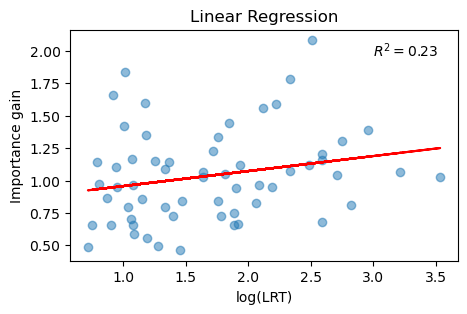

In [33]:
from scipy.stats import linregress
# Define the x and y values, filtering out np.nan values
x = all_merged[all_merged.p_value < 0.05]['logLRT'].dropna()
y = all_merged[all_merged.p_value < 0.05]['log_imp'].dropna()

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the linear regression line
line = slope * x + intercept

# Plot the data points and linear regression line
plt.scatter(x, y, alpha=0.5)
plt.plot(x, line, color='red')

# Add the R^2 value as text on the side
plt.text(0.95, 0.95, f'$R^2 = ${r_value:.2f}', ha='right', va='top', transform=plt.gca().transAxes)

# Set the labels and title
plt.xlabel('log(LRT)')
plt.ylabel('Importance gain')
plt.title('Linear Regression')

# Show the plot
plt.show()


In [34]:
linregress(x, y)

LinregressResult(slope=0.11573478414351296, intercept=0.8411695548101401, rvalue=0.22636577312858977, pvalue=0.0820012214729478, stderr=0.06539085201308761, intercept_stderr=0.11916502386963926)

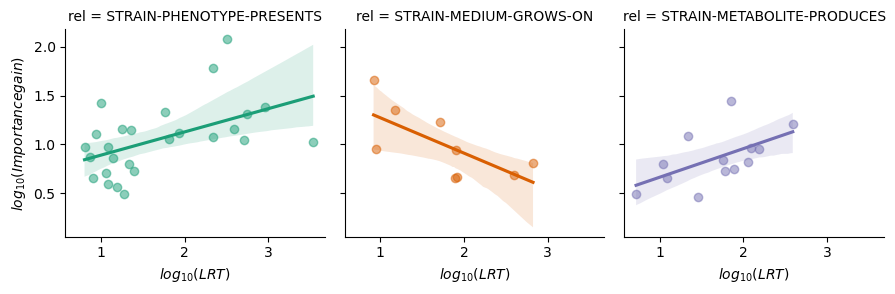

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the color palette to the accent color set
sns.set_palette("Dark2")

# Your code for plotting the dataframe
g = sns.lmplot(x="logLRT", y="log_imp", col="rel", hue="rel", data=all_merged[(all_merged.p_value < 0.05) & (all_merged.rel.isin(["STRAIN-PHENOTYPE-PRESENTS", "STRAIN-METABOLITE-PRODUCES", "STRAIN-MEDIUM-GROWS-ON"]))], aspect=1, height=3, scatter_kws={"alpha": 0.5})
g.set_axis_labels("$log_{10}(LRT)$", "$log_{10}(Importance gain)$")
plt.savefig("figures/xgboost/positive_selection.pdf", bbox_inches="tight")
